In [490]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy

from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [491]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.mean(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [505]:
edge_N, bin_N = load_histo("../Dati/All_noise_5M.dat")

channel = 5
edge_N = edge_N[channel]
bin_N = bin_N[channel]

rebin_fact = 4
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

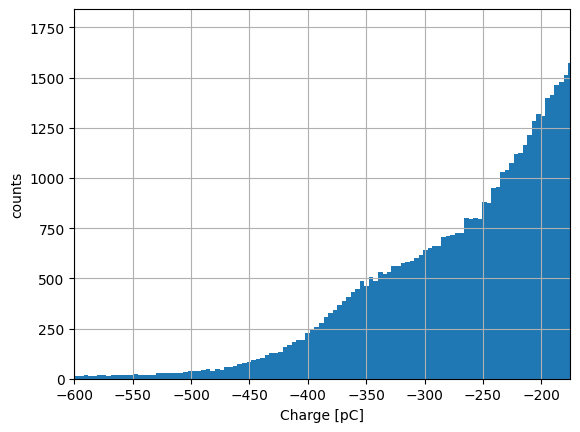

In [506]:
lim_list = [[-700, -165],  #ch0
            [-600, -155],  #ch1
            [-650, -175],  #ch2
            [-600, -145],  #ch3
            [-600, -165],  #ch4
            [-600, -175],  #ch5
            [-600, -155],  #ch6
            [-600, -180],  #ch7
            [-600, -170],  #ch8
            [-600, -160],  #ch9
            [-600, -120],  #ch10
            [-600, -165],  #ch11
            [-600, -100],  #ch12
            [-600, -100],  #ch13
            [-600, -100],  #ch14
            [-600, -100],  #ch15
            ]


lim_N = lim_list[channel]
plt.bar(centers_N, bin_N, width = 4)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [507]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

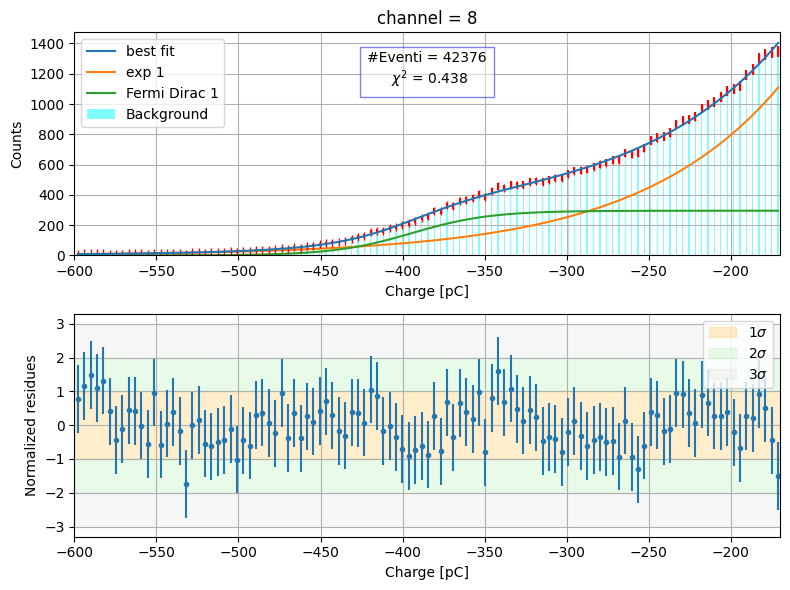

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 111
    # variables        = 5
    chi-square         = 46.3894825
    reduced chi-square = 0.43763663
    Akaike info crit   = -86.8427757
    Bayesian info crit = -73.2951247
    R-squared          = 0.99999719
[[Variables]]
    e1_amplitude:  7935.53476 +/- 156.998343 (1.98%) (init = 19839.3)
    e1_decay:     -86.9379709 +/- 0.73085653 (0.84%) (init = -79.48067)
    s1_amplitude:  295.163530 +/- 7.46154991 (2.53%) (init = 100)
    s1_center:    -394.196369 +/- 1.31788412 (0.33%) (init = -384.535)
    s1_sigma:      23.6568980 +/- 0.96721623 (4.09%) (init = 60.97143)
    g1_amplitude:  0 (fixed)
    g1_center:    -320 (fixed)
    g1_sigma:      25 (fixed)
    g1_fwhm:       58.8705000 +/- 0.00000000 (0.00%) 

In [495]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide

 
params = exp1.guess(bin_N, x = centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   #Indovina i parametri della prima gaussiana
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))

params["g1_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g1_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g1_sigma"].vary = False
params["s2_amplitude"].vary = False
params["s2_center"].vary = False
params["s2_sigma"].vary = False

params["s1_amplitude"].min = 0
params["s1_amplitude"].value = 100

model = exp1 + gauss1 + sigmoid1 + sigmoid2  

# Fit the model to the data
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.set_title(f'{channel = }')



_ = ax1.bar(centers_N, bin_N, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')


comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit', zorder = 10)
ax1.plot(centers_N, comps['e1_'], label='exp 1')
ax1.plot(centers_N, comps['s1_'], label='Fermi Dirac 1')


ax1.legend()
ax1.grid()
ax1.set_xlim(lim_N)

ax1.text(np.mean(lim_N), bin_N.max(), f'#Eventi = {int(bin_N.sum())}\n $\chi^2$ = {result.redchi:.3}', 
         fontsize=10, color='black', ha = "center", va = "top", 
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='square,pad=0.5'))


residueN = bin_N - result.best_fit
norm_resN = residueN / err_N

ax2.errorbar(centers_N, norm_resN, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
ax2.set_xlim(lim_N)
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [496]:
N_comp_ratio = float(result.params["e1_amplitude"].value / result.params["s1_amplitude"].value)
print(N_comp_ratio)

26.88521429745774


In [497]:
def get_noise_params(X, Y, err, mdl):
    prm = exp1.guess(Y, x = X)         
    prm.update(sigmoid1.guess(Y, x = X))

    rslt = mdl.fit(Y, prm, x = X, weights = 1 / err)

    exp_params = [rslt.params["e1_amplitude"].value, rslt.params["e1_decay"].value]
    fd_params = [rslt.params["s1_amplitude"].value, rslt.params["s1_sigma"].value, rslt.params["s1_center"].value]
    amp_ratio = rslt.params["e1_amplitude"].value / rslt.params["s1_amplitude"]

    return exp_params, fd_params, amp_ratio

In [498]:
model = exp1 + sigmoid1

get_noise_params(centers_N, bin_N, err_N, model)

([7935.536829773467, -86.93807467397971],
 [295.1614209888415, 23.656570262670947, -394.19673855536325],
 26.885413422892647)

In [512]:
edge_N, bin_N = load_histo("../Dati/All_noise_5M.dat")

for ch in range(edge_N.shape[0]):
    channel = ch

    lim_N = lim_list[ch]
    edge_N_loop = edge_N[channel]
    bin_N_loop = bin_N[channel]

    rebin_fact = 4
    bin_N_loop = rebin(bin_N_loop, rebin_fact)
    tmp = []
    for i in range(len(edge_N_loop)):
        if(i % rebin_fact == 0):
            tmp.append(edge_N_loop[i])

    tmp.append(edge_N_loop[-1])
    edge_N_loop = np.array(tmp)

    centers_N_loop = np.convolve(edge_N_loop, [0.5, 0.5], "valid")
    err_N_loop = np.sqrt(bin_N_loop)

    err_N_loop = err_N_loop[np.where((centers_N_loop > lim_N[0]) & (centers_N_loop < lim_N[1]))]
    bin_N_loop = bin_N_loop[np.where((centers_N_loop > lim_N[0]) & (centers_N_loop < lim_N[1]))]
    centers_N_loop = centers_N_loop[np.where((centers_N_loop > lim_N[0]) & (centers_N_loop < lim_N[1]))]

   


    print(get_noise_params(centers_N_loop, bin_N_loop, err_N_loop, model))


([5872.0753889875605, -99.89786936785984], [191.96790286732656, 24.517882233478076, -423.24622065209763], 30.588839599117186)
([6753.047493754211, -87.97192781862813], [243.79641092852498, 23.68291487611969, -383.6350914657158], 27.69953613358991)
([6557.154877906702, -102.51742745933713], [264.24410490259777, 30.025083470136014, -424.6074847533476], 24.814763153651867)
([9259.345199598509, -97.20643764871414], [373.1106228177097, 23.525417370953214, -403.9209180330813], 24.816621755962004)
([9936.314977914495, -87.57908120315457], [315.76044201513224, 20.87585435743279, -390.1219056364887], 31.467890387100216)
([9058.35797121111, -89.81103832613029], [317.46433337657226, 21.355681887106034, -391.45260798220494], 28.53346665707545)
([4072.79174601389, -157.95238051219613], [-152.39635544445454, 48.27163847104994, -599.6292422032154], -26.72499440118397)
([8757.525383917375, -90.0167832108673], [322.3306832125851, 23.83005326842403, -401.1014881656615], 27.169381756131386)
([7935.536829